In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import os
sys.path.append('../python/')

#set up matplotlib
os.environ['MPLCONFIGDIR'] = '../mplstyles'
print(os.environ['MPLCONFIGDIR'])
import matplotlib as mpl
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')
print(mpl.__version__) 
print(mpl.get_configdir())


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])


#set up numpy
import numpy as np

../mplstyles
3.0.3
/home/phys/villaa/analysis/misc/nrFano_Constraint/mplstyles


# Bin-Centering Correction with Edelweiss Binning

In the `ms_correction.ipynb` note, we examined the bin-centering correction with a finer binning (10 keV bins) and found the corrections were small (less than 2%). 

Here we explore what the bin-centering corrections are like using the binning used in the Edelweiss paper [REF]. 

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
f = h5py.File("data/k100_252Cf_shield_Edw_NRs_large.h5","r")


for i in f['nr_Fano']:
    print(i)

nr_energies
nr_hits


In [3]:
print(np.shape(f['nr_Fano/nr_energies']))
print(np.shape(f['nr_Fano/nr_hits']))

#get the data variables
nr_energies = np.asarray(f['nr_Fano/nr_energies'])
nr_hits = np.asarray(f['nr_Fano/nr_hits'])

nrsum = np.sum(nr_energies*1000,1)
print(np.shape(nrsum))
print(np.shape(nrsum[nrsum>5]))
f.close()

(347463, 24)
(347463,)
(347463,)
(88110,)


In [4]:
#constants
V=4.0 #volts
eps = 3.0/1000 #keV per pair, I usually use 3.3 for the numerator, but Edw. uses 3.
FWHM_to_SIG = 1 / (2*np.sqrt(2*np.log(2)))

#yield models
a=0.16
b=0.18
Qbar = lambda Er: a*Er**b

In [5]:
#start getting the resolutions
import EdwRes as er

aH_sim=0.035
heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7,aH_sim*FWHM_to_SIG)
#heatRes_GGA3 = er.get_heatRes_func(0.4, 2.7)

sigI_GGA3 = er.get_ionRes_func(1.3, 1.5, 3.1)

sigh_GGA3v = np.vectorize(heatRes_GGA3)
sigi_GGA3v = np.vectorize(sigI_GGA3)

In [6]:
#include a nominal Fano factor
F=0.0 #for NRs the factor is probably much higher than this

Enr = nr_energies*1000 #initial energies are in MeV
Enr_ss = nr_energies[nr_hits==1]*1000 #initial energies are in MeV

#step 1
EIhit_av = Qbar(Enr)*Enr
EIhit_av_ss = Qbar(Enr_ss)*Enr_ss

#step 2
Nhit_av = EIhit_av/eps
Nhit_av_ss = EIhit_av_ss/eps

#step 3
Nhit = np.around(np.random.normal(Nhit_av,np.sqrt(F*Nhit_av))).astype(np.float)
Nhit_ss = np.around(np.random.normal(Nhit_av_ss,np.sqrt(F*Nhit_av_ss))).astype(np.float)

#step 4
EHhit = (Enr + Nhit*V/1000.0)/(1+(V/(1000*eps)))
EHhit_ss = (Enr_ss + Nhit_ss*V/1000.0)/(1+(V/(1000*eps)))

#step 5
EIhit = eps*Nhit
EIhit_ss = eps*Nhit_ss

#step 6
EI = np.sum(EIhit,1)
EI_ss = np.sum(EIhit_ss,1)

#step 7
EH = np.sum(EHhit,1)
EH_ss = np.sum(EHhit_ss,1)

#step 8
EI = EI + np.random.normal(0.0,sigi_GGA3v(EI))
EI_ss = EI_ss + np.random.normal(0.0,sigi_GGA3v(EI_ss))

#step 9
EH = EH + np.random.normal(0.0,sigh_GGA3v(EH))
EH_ss = EH_ss + np.random.normal(0.0,sigh_GGA3v(EH_ss))

#step 10
Ernr = (1+(V/(1000*eps)))*EH - (V/(1000*eps))*EI
Ernr_ss = (1+(V/(1000*eps)))*EH_ss - (V/(1000*eps))*EI_ss

#step 11
Q = EI/Ernr
Q_ss = EI_ss/Ernr_ss

In [7]:
import pandas as pds

#create a dataframe
nr_df = pds.DataFrame(data={'yield':Q, 'energy':Ernr})
nr_ss_df = pds.DataFrame(data={'yield':Q_ss, 'energy':Ernr_ss})

#bin the data
bins = [5, 10, 20, 30, 40, 50, 70,150]
nr_df['binned'] = pds.cut(nr_df['energy'],bins)
nr_ss_df['binned'] = pds.cut(nr_ss_df['energy'],bins)

#print stats in each bin
s = nr_df.groupby(pds.cut(nr_df['energy'], bins=bins)).size()
s_ss = nr_ss_df.groupby(pds.cut(nr_ss_df['energy'], bins=bins)).size()
print (s)
print(s_ss)

#create list of vectors for histogrammin'
hist = nr_df.groupby(pds.cut(nr_df['energy'], bins=bins))['yield'].apply(list)
hist_ss = nr_ss_df.groupby(pds.cut(nr_ss_df['energy'], bins=bins))['yield'].apply(list)
print(hist)
print(hist_ss)

energy
(5, 10]      20141
(10, 20]     22969
(20, 30]     12809
(30, 40]      8270
(40, 50]      5822
(50, 70]      7332
(70, 150]     9430
dtype: int64
energy
(5, 10]      10274
(10, 20]     10647
(20, 30]      5258
(30, 40]      3163
(40, 50]      2150
(50, 70]      2639
(70, 150]     3214
dtype: int64
energy
(5, 10]      [0.022458214186158145, 0.024263003214635877, 0...
(10, 20]     [0.2692437248415515, 0.2664028484706858, 0.203...
(20, 30]     [0.36638431127060317, 0.29727053943254395, 0.3...
(30, 40]     [0.246828431349202, 0.24105570859549702, 0.290...
(40, 50]     [0.3283366790861378, 0.30794012759703815, 0.32...
(50, 70]     [0.26653498947017523, 0.3015251392675469, 0.25...
(70, 150]    [0.3125284664422951, 0.38112855587844696, 0.36...
Name: yield, dtype: object
energy
(5, 10]      [-0.026673139053143096, 0.13298145426872685, 0...
(10, 20]     [0.2741400382545511, 0.20763906428781242, 0.41...
(20, 30]     [0.34383854342572284, 0.27998992040270937, 0.3...
(30, 40]     [0.3294762

In [8]:
import histogram_yield as hy

qbootsigs,qbootsigerrsl,qbootsigerrsu = hy.QEr_Qboot(hist,bins)
qbootsigs_ss,qbootsigerrsl_ss,qbootsigerrsu_ss = hy.QEr_Qboot(hist_ss,bins)

(20141,)
0.1700143671880387    (0.16809746091752847, 0.1718988703900034)
(22969,)
0.08879937328692862    (0.08792730753636573, 0.08969027215830658)
(12809,)
0.05456630296437479    (0.053875358848296376, 0.05527212807448949)
(8270,)
0.04167919648259235    (0.04104859907121819, 0.04229600682531473)
(5822,)
0.0369795398494604    (0.0363324856146323, 0.037643119285412106)
(7332,)
0.03407229334668646    (0.03355487843677661, 0.03460360323901035)
(9430,)
0.03317715576235099    (0.03273056883025701, 0.033616771547203356)
(10274,)
0.1704158706086605    (0.16781534982858134, 0.1730237899173926)
(10647,)
0.0889222003357022    (0.08760788785959962, 0.09025709875409424)
(5258,)
0.051646382652664774    (0.05060308739553669, 0.0527184406584006)
(3163,)
0.037356384306024365    (0.03642375983604675, 0.03831101673286326)
(2150,)
0.02984567784494384    (0.02894322285194419, 0.030751123145359112)
(2639,)
0.025150596523756476    (0.02448794078285429, 0.02583837954786277)
(3214,)
0.022324093279152635    (0

In [9]:
#make functions for analytical bands
#modify heat resolution by adding aH

aH=0.065
heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7,aH*FWHM_to_SIG)
#heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7)
sigh_GGA3v_new = np.vectorize(heatRes_GGA3_new)

aH2=0.035
heatRes_GGA3_new2 = er.get_heatRes_func(0.4, 2.7,aH2*FWHM_to_SIG)
#heatRes_GGA3_new = er.get_heatRes_func(0.4, 2.7)
sigh_GGA3v_new2 = np.vectorize(heatRes_GGA3_new2)

#new resolution functions 
Ehee = lambda Er: ((1+(V/(1000*eps))*Qbar(Er))*Er)/(1+(V/(1000*eps)))
EIee = lambda Er: Qbar(Er)*Er


sigH_NR = lambda Er: sigh_GGA3v_new(Ehee(Er))

sigH_NR2 = lambda Er: sigh_GGA3v_new2(Ehee(Er))

sigI_NR = lambda Er: sigi_GGA3v(EIee(Er))



sigQnr = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2 \
                                     *Qbar(Etr)**2*sigH_NR(Etr)**2)

sigQnr2 = lambda Etr: (1/Etr)*np.sqrt((1+(V/(1000*eps))*Qbar(Etr))**2*sigI_NR(Etr)**2 + (1+(V/(1000*eps)))**2 \
                                     *Qbar(Etr)**2*sigH_NR2(Etr)**2)

print(sigQnr(20))
print(sigH_NR(10))
print(sigI_NR(10))
sigQnrv = np.vectorize(sigQnr)
sigQnrv2 = np.vectorize(sigQnr2)

0.05881961755608948
0.23096523083266213
0.8431667681790007


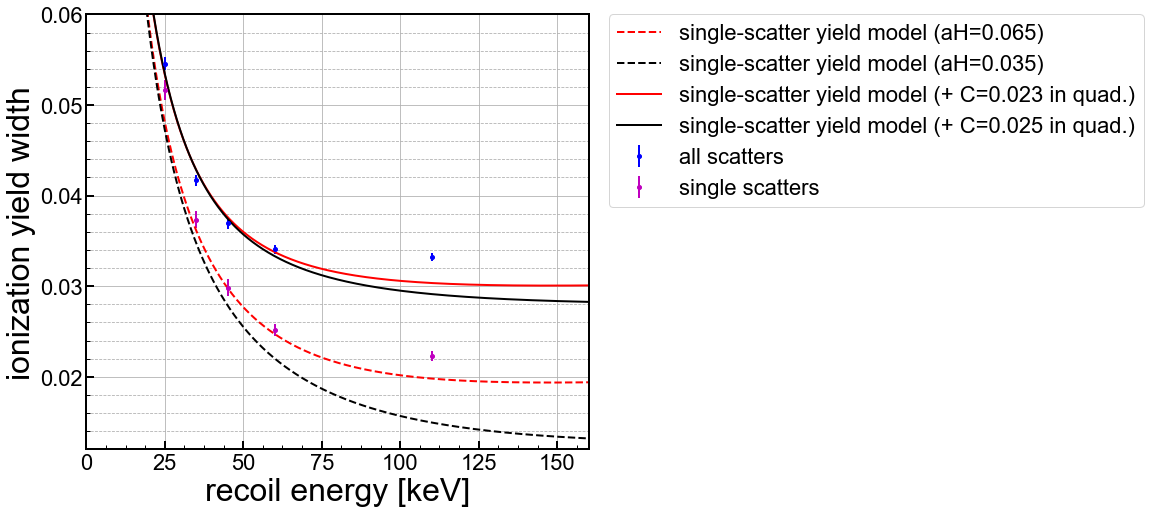

In [10]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

bins = np.asarray(bins)
xE = (bins[:-1] + bins[1:]) / 2

X=np.arange(0.1,160,0.1)


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH))
ax1.plot(X,sigQnrv2(X),color='k',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH2))
ax1.plot(X,np.sqrt(sigQnrv(X)**2+0.023**2),color='r',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.023))
ax1.plot(X,np.sqrt(sigQnrv2(X)**2+0.025**2),color='k',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.025))
ax1.errorbar(xE,qbootsigs, yerr=(qbootsigerrsl,qbootsigerrsu),color='b', marker='o', \
         markersize=4,linestyle='none',label='all scatters', linewidth=2)
ax1.errorbar(xE,qbootsigs_ss, yerr=(qbootsigerrsl_ss,qbootsigerrsu_ss),color='m', marker='o', \
         markersize=4,linestyle='none',label='single scatters', linewidth=2)



ymin = 0.012
ymax = 0.06



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 160) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
#ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.5),prop={'size':22})
lgd = ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

#plt.tight_layout()
#plt.savefig('figures/figure.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [11]:
#create list of vectors for histogrammin'
hist_E = nr_df.groupby(pds.cut(nr_df['energy'], bins=bins))['energy'].apply(list)
hist_ss_E = nr_ss_df.groupby(pds.cut(nr_ss_df['energy'], bins=bins))['energy'].apply(list)

print(hist_E)

energy
(5, 10]      [5.535695665199043, 9.792022775400882, 5.08298...
(10, 20]     [18.837770241384746, 14.601422914065214, 15.80...
(20, 30]     [22.703049916799742, 22.55241763460714, 24.034...
(30, 40]     [32.77990576551859, 31.302271599564953, 33.897...
(40, 50]     [42.07189706354586, 40.72034383772592, 42.4646...
(50, 70]     [61.425652922441515, 56.85623369069731, 63.584...
(70, 150]    [73.97993703447331, 94.60798578012967, 119.320...
Name: energy, dtype: object


In [12]:
qbootEs = np.zeros((np.shape(bins)[0]-1,))
qbootEs_ss = np.zeros((np.shape(bins)[0]-1,))

for i,Ev in enumerate(hist_E):
    #print(np.mean(Ev))
    qbootEs[i] = np.mean(Ev)
    
for i,Ev in enumerate(hist_ss_E):
    #print(np.mean(Ev))
    qbootEs_ss[i] = np.mean(Ev)

In [13]:
import imp
imp.reload(hy)

#try running with a linear interpolation of measured sigmas
qbootcorrs = hy.QEr_QbootBC(hist_E,qbootsigs,qbootEs,20,bins)
qbootcorrs_ss = hy.QEr_QbootBC(hist_ss_E,qbootsigs_ss,qbootEs_ss,20,bins)

#try running with a linear interpolation of expected sigmas
qbootcorrs = hy.QEr_QbootBC(hist_E,sigQnrv2(qbootEs),qbootEs,20,bins)
qbootcorrs_ss = hy.QEr_QbootBC(hist_ss_E,sigQnrv2(qbootEs_ss),qbootEs_ss,20,bins)

[0.99436381 0.9727349  0.9867339  0.99240687 0.99482108 0.98581033
 0.92503759]
[0.99422542 0.97186694 0.98393978 0.9896454  0.99160479 0.97384041
 0.85363392]
[0.99405759 0.97105216 0.98410445 0.98860016 0.99013692 0.96634347
 0.75027302]
[0.99397143 0.97167866 0.98430576 0.98880442 0.99036562 0.96602326
 0.75370128]


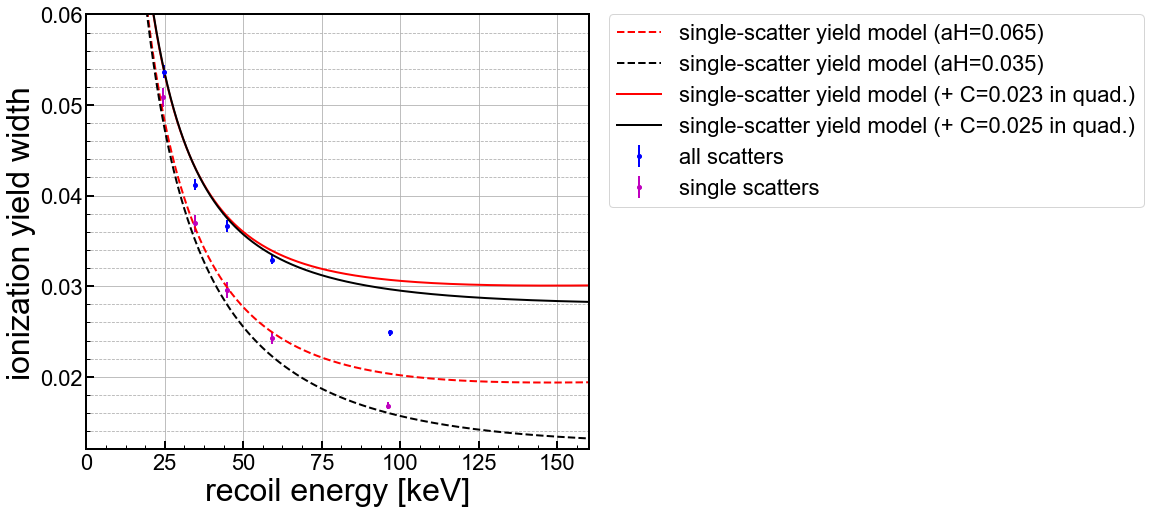

In [14]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes



X=np.arange(0.1,160,0.1)


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH))
ax1.plot(X,sigQnrv2(X),color='k',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH2))
ax1.plot(X,np.sqrt(sigQnrv(X)**2+0.023**2),color='r',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.023))
ax1.plot(X,np.sqrt(sigQnrv2(X)**2+0.025**2),color='k',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.025))
ax1.errorbar(qbootEs,qbootsigs*qbootcorrs, yerr=(qbootsigerrsl*qbootcorrs,qbootsigerrsu*qbootcorrs),color='b', marker='o', \
         markersize=4,linestyle='none',label='all scatters', linewidth=2)
ax1.errorbar(qbootEs_ss,qbootsigs_ss*qbootcorrs_ss, yerr=(qbootsigerrsl_ss*qbootcorrs_ss,qbootsigerrsu_ss*qbootcorrs_ss),color='m', marker='o', \
         markersize=4,linestyle='none',label='single scatters', linewidth=2)



ymin = 0.012
ymax = 0.06



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 160) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
#ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.5),prop={'size':22})
lgd = ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

#plt.tight_layout()
#plt.savefig('figures/figure.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [15]:
import imp
imp.reload(hy)

qbootcorrs = hy.QEr_QbootBC_iterative(hist_E,qbootsigs,qbootEs,20,bins)
qbootcorrs_ss = hy.QEr_QbootBC_iterative(hist_ss_E,qbootsigs_ss,qbootEs_ss,20,bins)

[0.99436381 0.9727349  0.9867339  0.99240687 0.99482108 0.98581033
 0.92503759]
[0.9941351  0.97133653 0.98703077 0.99239811 0.99475495 0.98529478
 0.91309661]
[0.99389376 0.96981076 0.98734736 0.99238214 0.99468606 0.98467523
 0.89594607]
[0.99363881 0.96813842 0.98768168 0.9923589  0.99461402 0.98391735
 0.87016426]
[0.99336917 0.9662962  0.98803122 0.99232837 0.99453834 0.98296712
 0.82920088]
[0.96977259 0.85723313 0.93840081 0.96245139 0.97369564 0.92501797
 0.54603311]
[0.99422542 0.97186694 0.98393978 0.9896454  0.99160479 0.97384041
 0.85363392]
[0.99398314 0.97034122 0.98419732 0.98960215 0.99141445 0.97195821
 0.80862366]
[0.9937267  0.96866838 0.98448605 0.98954716 0.99120972 0.96955875
 0.73252576]
[0.99345496 0.96682523 0.98480485 0.9894799  0.99098755 0.96641453
 0.59986988]
[0.9931666  0.96478336 0.98515201 0.98939978 0.99074357 0.96226656
 0.38783329]
[0.96894947 0.8520875  0.92494027 0.94875815 0.95672885 0.85343089
 0.11763679]


# Alternate Approach

Another way to test this is to see what happens if we correct for at least the mean of $Q$ by using $\bar{Q}(E_R)$, the yield model. If we do this _before_ the data is binned and used to get the standard deviation, at least the bin-centering correction does not have to account for the drift in the mean of the $Q$ distribution. 

In [16]:
#create a new dataframe
Qcorr = Q - Qbar(np.abs(Ernr))
Qcorr_ss = Q_ss - Qbar(np.abs(Ernr_ss))
nr_corr_df = pds.DataFrame(data={'yield':Qcorr, 'energy':Ernr})
nr_corr_ss_df = pds.DataFrame(data={'yield':Qcorr_ss, 'energy':Ernr_ss})

#bin the data
#bins = [5, 10, 20, 30, 40, 50, 70,150]
nr_corr_df['binned'] = pds.cut(nr_corr_df['energy'],bins)
nr_corr_ss_df['binned'] = pds.cut(nr_corr_ss_df['energy'],bins)

#print stats in each bin
s_corr = nr_corr_df.groupby(pds.cut(nr_corr_df['energy'], bins=bins)).size()
s_corr_ss = nr_corr_ss_df.groupby(pds.cut(nr_corr_ss_df['energy'], bins=bins)).size()
print (s_corr)
print(s_corr_ss)

#create list of vectors for histogrammin'
hist_corr = nr_corr_df.groupby(pds.cut(nr_corr_df['energy'], bins=bins))['yield'].apply(list)
hist_corr_ss = nr_corr_ss_df.groupby(pds.cut(nr_corr_ss_df['energy'], bins=bins))['yield'].apply(list)
print(hist_corr)
print(hist_corr_ss)

energy
(5, 10]      20141
(10, 20]     22969
(20, 30]     12809
(30, 40]      8270
(40, 50]      5822
(50, 70]      7332
(70, 150]     9430
dtype: int64
energy
(5, 10]      10274
(10, 20]     10647
(20, 30]      5258
(30, 40]      3163
(40, 50]      2150
(50, 70]      2639
(70, 150]     3214
dtype: int64
energy
(5, 10]      [-0.1952581032012491, -0.21699238258727016, 0....
(10, 20]     [-0.002165929460421656, 0.007157415063708872, ...
(20, 30]     [0.08570193839319429, 0.016924295622897045, 0....
(30, 40]     [-0.05303904782435717, -0.056332425917698215, ...
(40, 50]     [0.014691540993265584, -0.0038670019532038857,...
(50, 70]     [-0.06922036191023162, -0.029590762692836503, ...
(70, 150]    [-0.034656167103363666, 0.018228541001586995, ...
Name: yield, dtype: object
energy
(5, 10]      [-0.24109187926827091, -0.10233125064371182, -...
(10, 20]     [0.0018415682318272952, -0.056833562161626106,...
(20, 30]     [0.06053401411215775, -0.0022286997500885475, ...
(30, 40]     [0.0294418

In [17]:
qcorrsigs,qcorrsigerrsl,qcorrsigerrsu = hy.QEr_Qboot(hist_corr,bins)
qcorrsigs_ss,qcorrsigerrsl_ss,qcorrsigerrsu_ss = hy.QEr_Qboot(hist_corr_ss,bins)

(20141,)
0.16942319535413486    (0.1675683522859924, 0.17130930504803896)
(22969,)
0.08814660221425569    (0.0872661566914464, 0.08902027796245335)
(12809,)
0.054221602737667816    (0.05354696284057973, 0.05491325636282726)
(8270,)
0.04149845271554133    (0.04086679485391632, 0.04210195143959367)
(5822,)
0.036815328389127065    (0.036153684542918806, 0.03747883091715433)
(7332,)
0.033558623096880104    (0.03303936876396767, 0.03407785518926351)
(9430,)
0.031139491455518583    (0.030718754189814124, 0.031548603509751534)
(10274,)
0.16986830656348886    (0.16723929331923987, 0.1725072121001323)
(10647,)
0.08822093547439377    (0.08692379198933374, 0.08953612954617225)
(5258,)
0.05125789159900367    (0.05023702010859348, 0.05225839945065895)
(3163,)
0.03710938632649356    (0.036175071571835096, 0.03805990972720256)
(2150,)
0.02963254509579286    (0.028741504814199202, 0.030546173974154968)
(2639,)
0.02441478020689394    (0.023758510947061565, 0.02507139661829355)
(3214,)
0.017877961712390

In [18]:
#try running with a linear interpolation of measured sigmas
qcorrcorrs = hy.QEr_QbootBC(hist_E,qcorrsigs,xE,20,bins)
qcorrcorrs_ss = hy.QEr_QbootBC(hist_ss_E,qcorrsigs_ss,xE,20,bins)

[0.98085949 0.93498752 0.97026893 0.98588213 0.99267397 0.98304641
 0.90040683]
[0.9805492  0.92815554 0.9608728  0.98027369 0.9873773  0.9661546
 0.74327114]


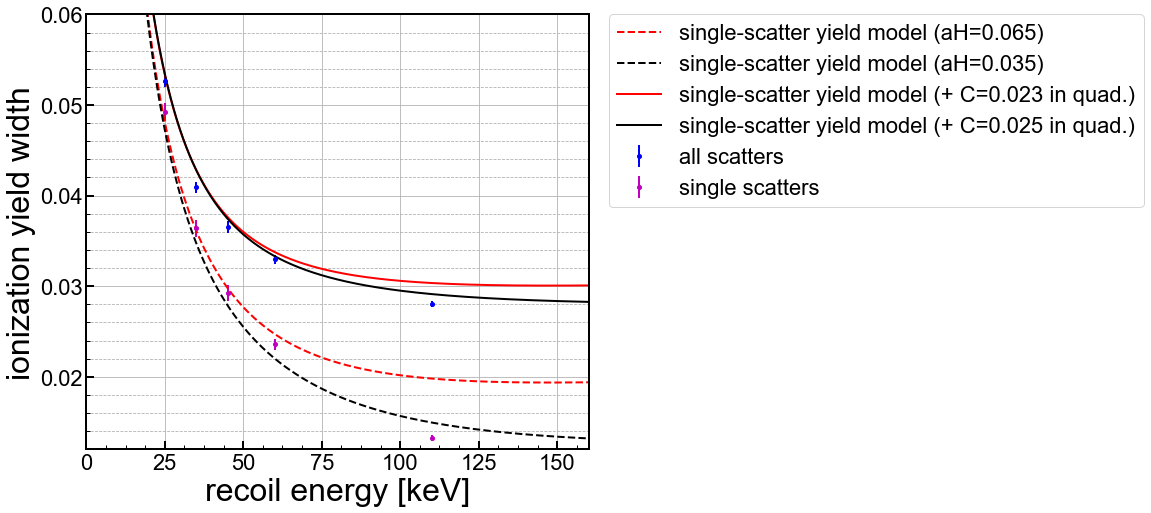

In [19]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

bins = np.asarray(bins)
xE = (bins[:-1] + bins[1:]) / 2

X=np.arange(0.1,160,0.1)


ax1.plot(X,sigQnrv(X),color='r',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH))
ax1.plot(X,sigQnrv2(X),color='k',linestyle="--",linewidth=2,label='single-scatter yield model (aH={:1.3})'.format(aH2))
ax1.plot(X,np.sqrt(sigQnrv(X)**2+0.023**2),color='r',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.023))
ax1.plot(X,np.sqrt(sigQnrv2(X)**2+0.025**2),color='k',linestyle="-",linewidth=2,\
         label='single-scatter yield model (+ C={:1.3f} in quad.)'.format(0.025))
ax1.errorbar(xE,qcorrsigs*qcorrcorrs, yerr=(qcorrsigerrsl*qcorrcorrs,qcorrsigerrsu*qcorrcorrs),color='b', marker='o', \
         markersize=4,linestyle='none',label='all scatters', linewidth=2)
ax1.errorbar(xE,qcorrsigs_ss*qcorrcorrs_ss, yerr=(qcorrsigerrsl_ss*qcorrcorrs_ss,qcorrsigerrsu_ss*qcorrcorrs_ss),color='m', marker='o', \
         markersize=4,linestyle='none',label='single scatters', linewidth=2)



ymin = 0.012
ymax = 0.06



ax1.set_yscale('linear')
#ax1.set_yscale('log')
ax1.set_xlim(0, 160) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'recoil energy [keV]',**axis_font)
ax1.set_ylabel('ionization yield width',**axis_font)
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
#ax1.legend(loc=1,prop={'size':22})
#ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.5),prop={'size':22})
lgd = ax1.legend(bbox_to_anchor=(1.04,1),borderaxespad=0,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

#plt.tight_layout()
#plt.savefig('figures/figure.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# Bin Correction with Large "C"

The bin-centering corrections also probably decrease to a certain extent with large C's. This is because a constant value of C will dominate over much of the energy range.

In [22]:
import observable_simulations as osim
imp.reload(er)
imp.reload(osim)

Q,Ernr,Q_ss,Ernr_ss = osim.simQEr('GGA3',V=4.0,aH=None,C=None)

print(np.shape(Q))

[1.3, 1.5, 0.4, 3.1, 2.7]
(347463,)
